In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.dataloader import create_dataloader, create_dataset
from utils.inference import inference
from utils.utils import sorted_file_paths, find_latest_checkpoint

from sklearn.metrics import r2_score
from metrics.balanced_MAE import balanced_MAE, get_bin_edges

from models.resnet import load_resnet_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate performance on validation set

In [14]:
def count_unique_values(arr):
    # Find the unique elements and their counts
    unique_values, counts = np.unique(arr, return_counts=True)
    
    # Create a dictionary from unique_values and counts
    value_counts = dict(zip(unique_values, counts))
    
    return value_counts

def sort_bins_by_count(value_counts):
    # Sort the dictionary by values and return the sorted keys
    sorted_keys = sorted(value_counts, key=value_counts.get)
    return sorted_keys

def MAE(true, pred):
    bin_edges = get_bin_edges()
    true_label_bins = np.digitize(true, bin_edges, right=True)
    bin_index_from_least_to_most = sort_bins_by_count(count_unique_values(true_label_bins))

    mae = []
    for i in bin_index_from_least_to_most:
        bin_mask = (true_label_bins == i)
        current_labels = true[bin_mask]
        current_predictions = pred[bin_mask]
        bin_mae = np.mean(np.abs(current_labels - current_predictions))
        mae.append(bin_mae)
    return mae

def validate(experiment, path, val_loader):
    checkpoint = f'{find_latest_checkpoint(path)}'
    print(checkpoint)
    model = load_resnet_model()
    true_labels, predictions = inference(model, checkpoint, val_loader, device)

    results = [
        f'Experiment {path} {experiment}',
        f'Balanced MAE: {balanced_MAE(true_labels, predictions)}', 
        f'R2: {r2_score(true_labels, predictions)}'
    ]
    
    with open('readme.md', 'a') as readme_file:
    # Write each line to the file, followed by a newline character
        for line in results:
            readme_file.write(line + '\n')
        readme_file.write('\n')
    
    return MAE(true_labels, predictions)

In [15]:
experiments = [
    ['L2', './experiments/ex_2'],
    ['L3', './experiments/ex_4'],
    ['Weigthed L2 (alpha=0.25)', './experiments/ex_5'],
    ['Weigthed L2 (alpha=0.5)', './experiments/ex_6'],
    ['Weighted sampling (alpha=0.25)', './experiments/ex_7'],
    ['Weighted sampling (alpha=0.5)', './experiments/ex_8'],
    ['BMC', './experiments/ex_9'],
]

In [16]:
val_files = sorted_file_paths('./data/records_location/val')
val_dataset = create_dataset(val_files, half= False)
val_loader = create_dataloader(val_dataset, 64)

In [17]:
MAE_records = []
for experiment, path in experiments:
    MAE_records.append(validate(experiment, path, val_loader))

./experiments/ex_2\checkpoint_epoch_6.pth


100%|██████████| 35/35 [00:41<00:00,  1.18s/it]


./experiments/ex_4\checkpoint_epoch_20.pth


100%|██████████| 35/35 [00:53<00:00,  1.54s/it]


./experiments/ex_5\checkpoint_epoch_25.pth


100%|██████████| 35/35 [00:43<00:00,  1.23s/it]


./experiments/ex_6\checkpoint_epoch_26.pth


100%|██████████| 35/35 [00:46<00:00,  1.34s/it]


./experiments/ex_7\checkpoint_epoch_23.pth


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]


./experiments/ex_8\checkpoint_epoch_17.pth


100%|██████████| 35/35 [00:46<00:00,  1.32s/it]


./experiments/ex_9\checkpoint_epoch_50.pth


100%|██████████| 35/35 [00:45<00:00,  1.29s/it]


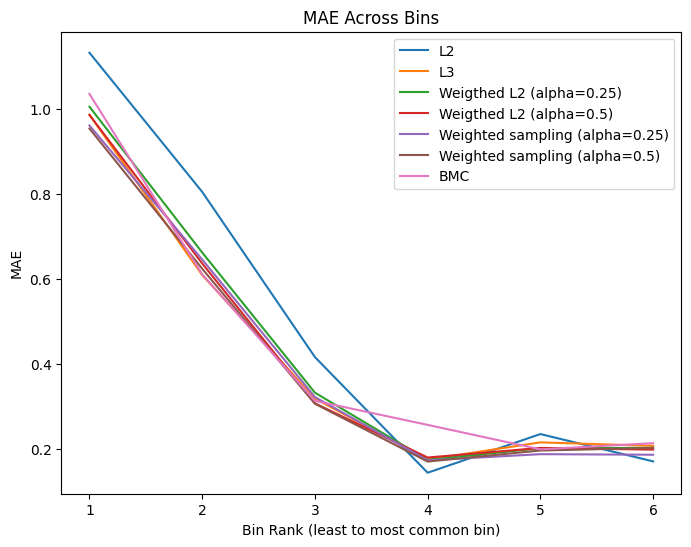

In [18]:
plt.figure(figsize=(8, 6))
for i in range(0, 7):
    plt.plot(range(1,7), MAE_records[i], label=experiments[i][0])

# Adding title and labels
plt.title('MAE Across Bins')
plt.xlabel('Bin Rank (least to most common bin)')
plt.ylabel('MAE')

# Adding a legend
plt.legend()

# Display the plot
plt.show()